## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
display(train.describe())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4


,age_approx,target,tfrecord,width,height,patient_code
count,33058.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000
mean,48.870016,0.017630,6.894826,4039.630381,2678.758256,734.894977
std,14.380360,0.131603,4.390486,2109.145590,1437.617626,528.907365
min,0.000000,0.000000,-1.000000,640.000000,480.000000,0.000000
25%,40.000000,0.000000,3.000000,1872.000000,1053.000000,271.000000
50%,50.000000,0.000000,7.000000,5184.000000,3456.000000,659.000000
75%,60.000000,0.000000,11.000000,6000.000000,4000.000000,1109.000000
max,90.000000,1.000000,14.000000,6000.000000,6000.000000,2055.000000


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Missing values

In [4]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mode()[0], inplace=True)
test['age_approx'].fillna(train['age_approx'].mode()[0], inplace=True)
# anatom_site_general_challenge (NaN)
# train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [5]:
### Label ecoding
enc = LabelEncoder()
train['sex_enc'] = enc.fit_transform(train['sex'].astype('str'))
test['sex_enc'] = enc.transform(test['sex'].astype('str'))

### One-hot ecoding
# train = pd.concat([train, pd.get_dummies(train['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# test = pd.concat([test, pd.get_dummies(test['sex'], prefix='sex_enc', drop_first=True)], axis=1)

### Mean ecoding
target_mean = train['target'].mean()
# Sex
sex_mean = train.groupby(['sex'])['target'].mean().reset_index().rename(columns={'target': 'sex_mean'})
train = train.merge(sex_mean, on=['sex'], how='left')
test = test.merge(sex_mean, on=['sex'], how='left')
train['sex_mean'].fillna(target_mean, inplace=True)
test['sex_mean'].fillna(target_mean, inplace=True)

# Age
age_mean = train.groupby(['age_approx'])['target'].mean().reset_index().rename(columns={'target': 'age_mean'})
train = train.merge(age_mean, on=['age_approx'], how='left')
test = test.merge(age_mean, on=['age_approx'], how='left')
train['age_mean'].fillna(target_mean, inplace=True)
test['age_mean'].fillna(target_mean, inplace=True)

# Sex_Age
sex_age_mean = train.groupby(['sex', 'age_approx'])['target'].mean().reset_index().rename(columns={'target': 'sex_age_mean'})
train = train.merge(sex_age_mean, on=['sex', 'age_approx'], how='left')
test = test.merge(sex_age_mean, on=['sex', 'age_approx'], how='left')
train['sex_age_mean'].fillna(target_mean, inplace=True)
test['sex_age_mean'].fillna(target_mean, inplace=True)

# Extra
bias = 15
sex_age_mean_2 = train.groupby(['sex','age_approx'])['target'].agg(['mean','count']).reset_index()
sex_age_mean_2['sex_age_mean_2'] = ((sex_age_mean_2['mean']*sex_age_mean_2['count'])+(target_mean*bias))/(sex_age_mean_2['count']+bias)
train = train.merge(sex_age_mean_2[['sex','age_approx', 'sex_age_mean_2']], on=['sex','age_approx'], how='left')
test = test.merge(sex_age_mean_2[['sex','age_approx', 'sex_age_mean_2']], on=['sex','age_approx'], how='left')

train['sex_age_mean_2'].fillna(target_mean, inplace=True)
test['sex_age_mean_2'].fillna(target_mean, inplace=True)

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code,sex_enc,sex_mean,age_mean,sex_age_mean,sex_age_mean_2
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0,1,0.021231,0.011910,0.011664,0.011699
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1,0,0.013766,0.011910,0.012232,0.012273
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2,0,0.013766,0.012412,0.008646,0.008710
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3,0,0.013766,0.011910,0.012232,0.012273
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4,0,0.013766,0.016736,0.017094,0.017098


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,sex_mean,age_mean,sex_age_mean,sex_age_mean_2
0,ISIC_0052060,IP_3579794,male,70.0,NaN,1,0.021231,0.029472,0.033141,0.032975
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.021231,0.006711,0.007316,0.007402
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,0.013766,0.016736,0.017094,0.017098
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,0.013766,0.012412,0.008646,0.008710
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,0.013766,0.011910,0.012232,0.012273


# Model

In [6]:
features = ['age_approx', 'sex_mean', 'age_mean', 'sex_age_mean', 'sex_age_mean_2']

enc_features  = [col for col in train.columns if 'enc' in col]

features += enc_features

# External features
# features += ext_fts
print(features)

['age_approx', 'sex_mean', 'age_mean', 'sex_age_mean', 'sex_age_mean_2', 'sex_enc']


In [7]:
# Hyperparameter grid
param_grid = {
    'max_depth': list(range(2, 12, 2)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.3, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'scale_pos_weight': list(np.linspace(1, (len(train[train['target'] == 0]) / len(train[train['target'] == 1])), 10)),
}


skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)

def get_idxs():
    for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
        x_train = train[train['tfrecord'].isin(idxT)]
        x_valid = train[~train['tfrecord'].isin(idxT)]
        yield x_train.index, x_valid.index


# Model
model = XGBClassifier(n_estimators=300, random_state=SEED)

grid_search = RandomizedSearchCV(param_distributions=param_grid, estimator=model, scoring='roc_auc', 
                                 cv=iter(get_idxs()), n_jobs=-1, n_iter=100, verbose=1)
result = grid_search.fit(train[features], train['target'])

print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
params = result.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


Best: 0.688336 using {'subsample': 0.6767676767676768, 'scale_pos_weight': 37.481735159817354, 'reg_lambda': 0.7346938775510203, 'reg_alpha': 0.6530612244897959, 'max_depth': 2, 'learning_rate': 0.006152620021796307, 'colsample_bytree': 0.6888888888888889}
0.669664 (0.021600) with: {'subsample': 0.7171717171717171, 'scale_pos_weight': 49.64231354642314, 'reg_lambda': 0.5918367346938775, 'reg_alpha': 0.36734693877551017, 'max_depth': 4, 'learning_rate': 0.023422900579365236, 'colsample_bytree': 0.45555555555555555}
0.670182 (0.023413) with: {'subsample': 0.51010101010101, 'scale_pos_weight': 43.56202435312025, 'reg_lambda': 0.6122448979591836, 'reg_alpha': 0.7755102040816326, 'max_depth': 8, 'learning_rate': 0.11650307053484622, 'colsample_bytree': 1.0}
0.669122 (0.021993) with: {'subsample': 0.9797979797979799, 'scale_pos_weight': 13.160578386605785, 'reg_lambda': 0.4081632653061224, 'reg_alpha': 0.36734693877551017, 'max_depth': 10, 'learning_rate': 0.12775485451762533, 'colsample_byt

# Training

In [8]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0
model_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'train' if x['tfrecord'] in idxT else 'validation', axis=1)
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    model = XGBClassifier(**params, random_state=SEED)
    
    model.fit(x_train[features], y_train, eval_set=[(x_valid[features], y_valid)], eval_metric='auc', verbose=0)
    model_list.append(model)

    # Evaludation
    preds = model.predict_proba(train[features])[:, 1]
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = model.predict_proba(test[features])[:, 1]
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Model evaluation

In [9]:
def func(x):
    if x['fold_1'] == 'validation':
        return x['pred_fold_1']
    elif x['fold_2'] == 'validation':
        return x['pred_fold_2']
    elif x['fold_3'] == 'validation':
        return x['pred_fold_3']
    elif x['fold_4'] == 'validation':
        return x['pred_fold_4']
    elif x['fold_5'] == 'validation':
        return x['pred_fold_5']
    
train['pred'] = train.apply(lambda x: func(x), axis=1)

auc_oof = roc_auc_score(train['target'], train['pred'])
print(f'Overall OOF AUC = {auc_oof:.3f}')

df_oof = train[['image_name', 'target', 'pred']]
df_oof.to_csv('oof.csv', index=False)
display(df_oof.head())
display(df_oof.describe().T)

Overall OOF AUC = 0.681


,image_name,target,pred
0,ISIC_2637011,0,0.425702
1,ISIC_0015719,0,0.424776
2,ISIC_0052212,0,0.378841
3,ISIC_0068279,0,0.424776
4,ISIC_0074268,0,0.440472


,count,mean,std,min,25%,50%,75%,max
target,33126.0,0.017630,0.131603,0.0000,0.000000,0.000000,0.000000,1.000000
pred,33126.0,0.435635,0.063099,0.3532,0.378841,0.429651,0.466554,0.636715


# Feature importance

Fold: 1


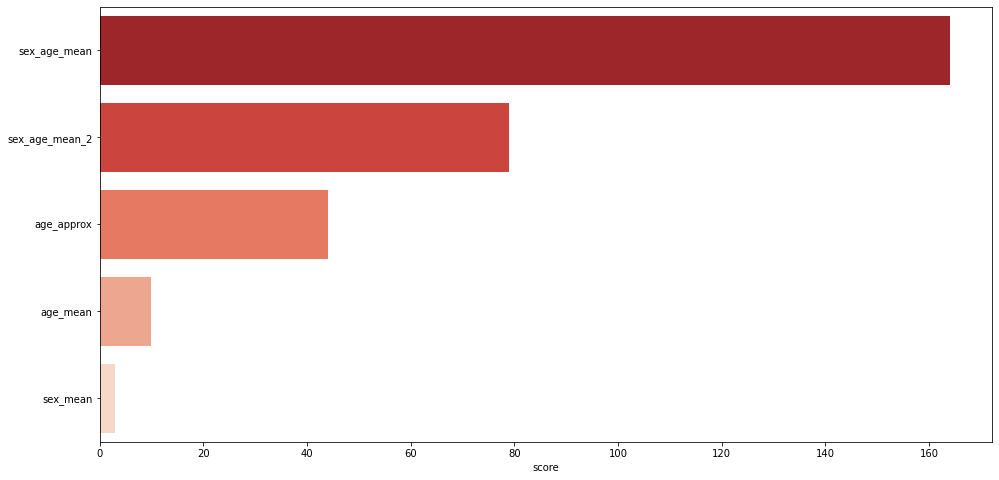

Fold: 2


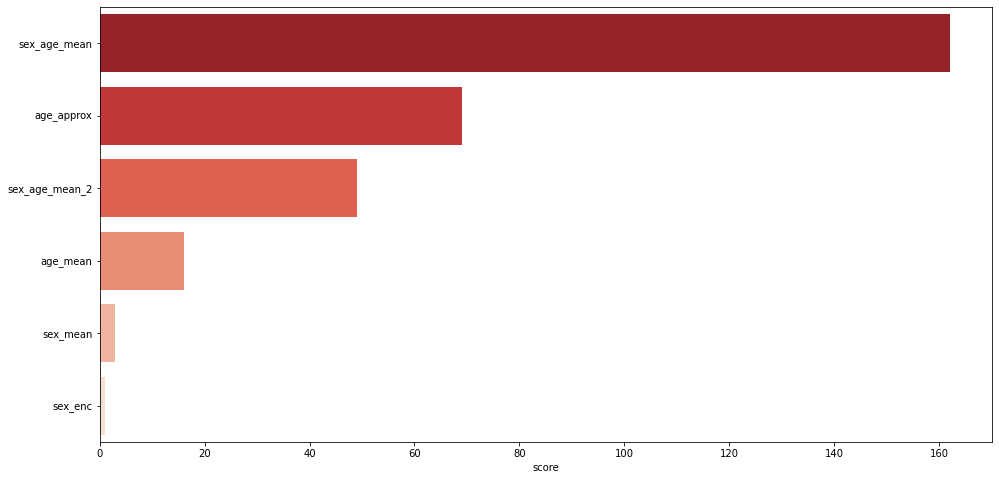

Fold: 3


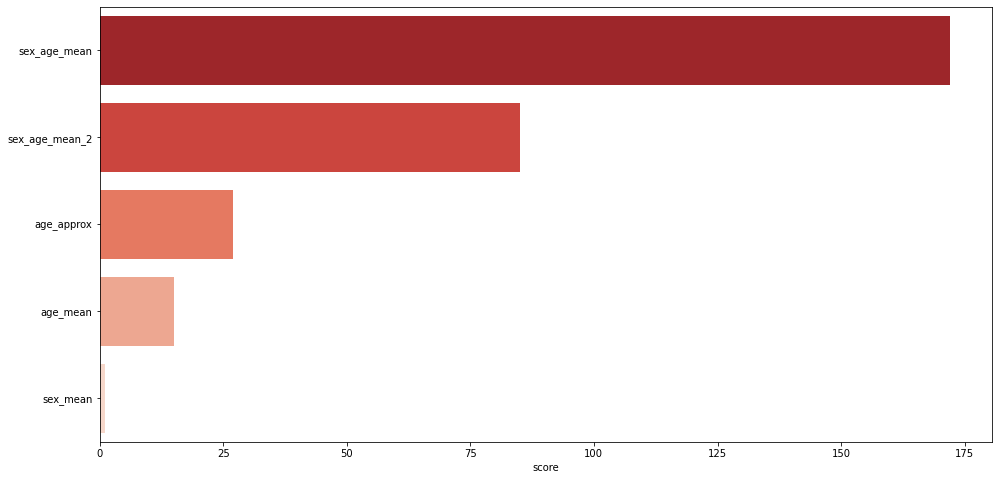

Fold: 4


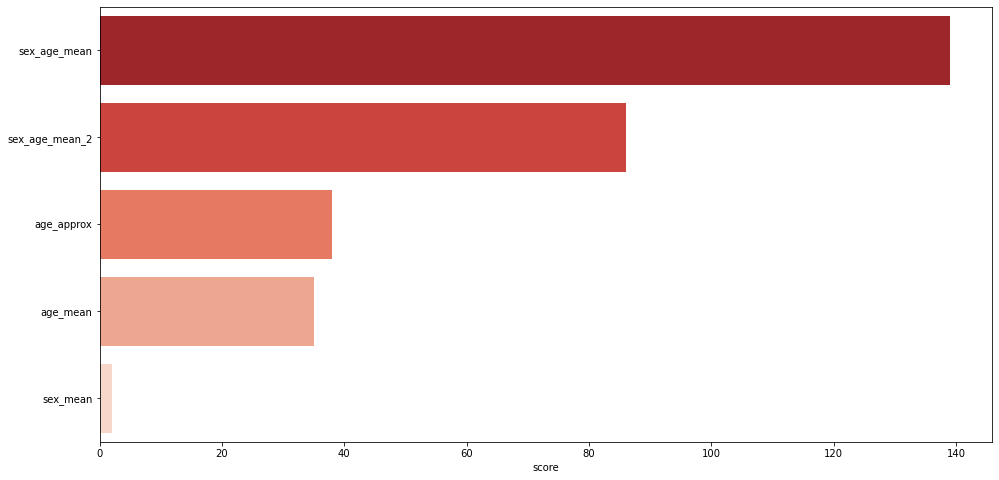

Fold: 5


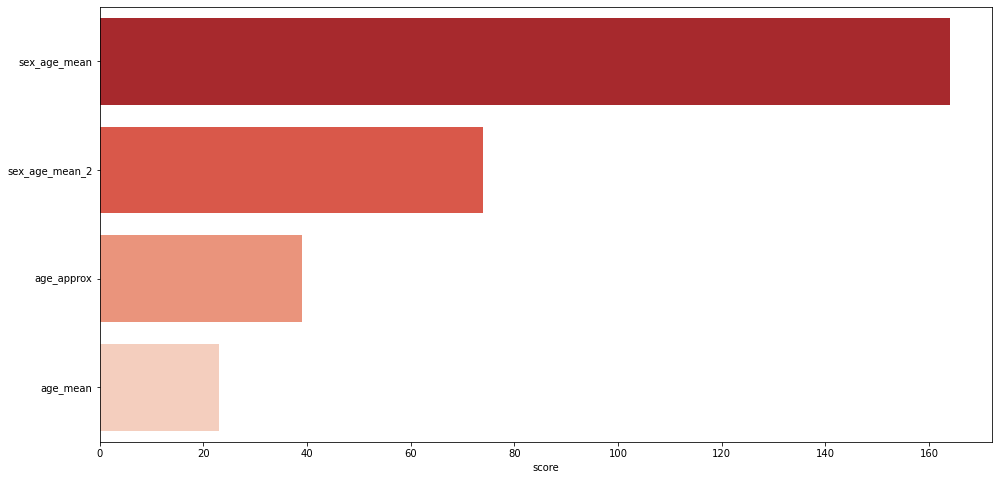

In [10]:
for n_fold, model in enumerate(model_list):
    print(f'Fold: {n_fold + 1}')
    feature_importance = model.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                              columns=['score']).sort_values(by='score',
                                                             ascending=False)
    plt.figure(figsize=(16, 8))
    sns.barplot(x=importance.score.iloc[:20],
                y=importance.index[:20],
                orient='h',
                palette='Reds_r')

    plt.show()

# Model evaluation

In [11]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.696625,0.689570,0.007055,0.694104,0.700423,0.693156,0.702218,0.690144,0.715208,0.705933,0.651876,0.699789,0.678127
Accuracy,0.817635,0.809672,0.007962,0.866379,0.850789,0.824490,0.848020,0.787835,0.745491,0.831990,0.819830,0.777480,0.784232
Precision,0.043575,0.038090,0.005485,0.049643,0.039960,0.042572,0.045455,0.040347,0.034773,0.045108,0.036036,0.040206,0.034228
Recall,0.435056,0.409370,0.025686,0.359140,0.336134,0.412903,0.394958,0.479570,0.521008,0.419355,0.369748,0.504310,0.425000
F1-score,0.078955,0.069435,0.009520,0.087229,0.071429,0.077186,0.081526,0.074433,0.065195,0.081454,0.065672,0.074475,0.063354
Support,464.800000,119.200000,345.600000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,464.000000,120.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.696625,0.689570,0.007055,0.694104,0.700423,0.693156,0.702218,0.690144,0.715208,0.705933,0.651876,0.699789,0.678127
male,0.683926,0.678806,0.005120,0.680752,0.696378,0.664251,0.746935,0.693619,0.643782,0.685753,0.671459,0.695253,0.635476
female,0.688606,0.682335,0.006271,0.678643,0.717016,0.702979,0.621582,0.663060,0.781454,0.711598,0.594173,0.686750,0.697450
head/neck,0.770119,0.776600,-0.006481,0.777482,0.723973,0.745146,0.877618,0.778947,0.765505,0.769121,0.765785,0.779897,0.750118
upper extremity,0.709348,0.695261,0.014088,0.702384,0.726309,0.714703,0.680402,0.695429,0.720916,0.719952,0.656186,0.714274,0.692492
lower extremity,0.625775,0.618585,0.007190,0.624950,0.630259,0.633328,0.584679,0.621967,0.657274,0.626171,0.599393,0.622459,0.621323
torso,0.703589,0.695988,0.007601,0.694994,0.727921,0.697558,0.713421,0.701633,0.701980,0.715304,0.657692,0.708455,0.678925
0 <= age < 26,0.689858,0.657655,0.032202,0.700342,0.618644,0.754792,0.352459,0.664280,0.913194,0.647671,0.733818,0.682204,0.670160
26 <= age < 40,0.615093,0.606707,0.008387,0.607746,0.603127,0.611468,0.648743,0.627550,0.558934,0.633727,0.551972,0.594975,0.670758


# Adversarial Validation

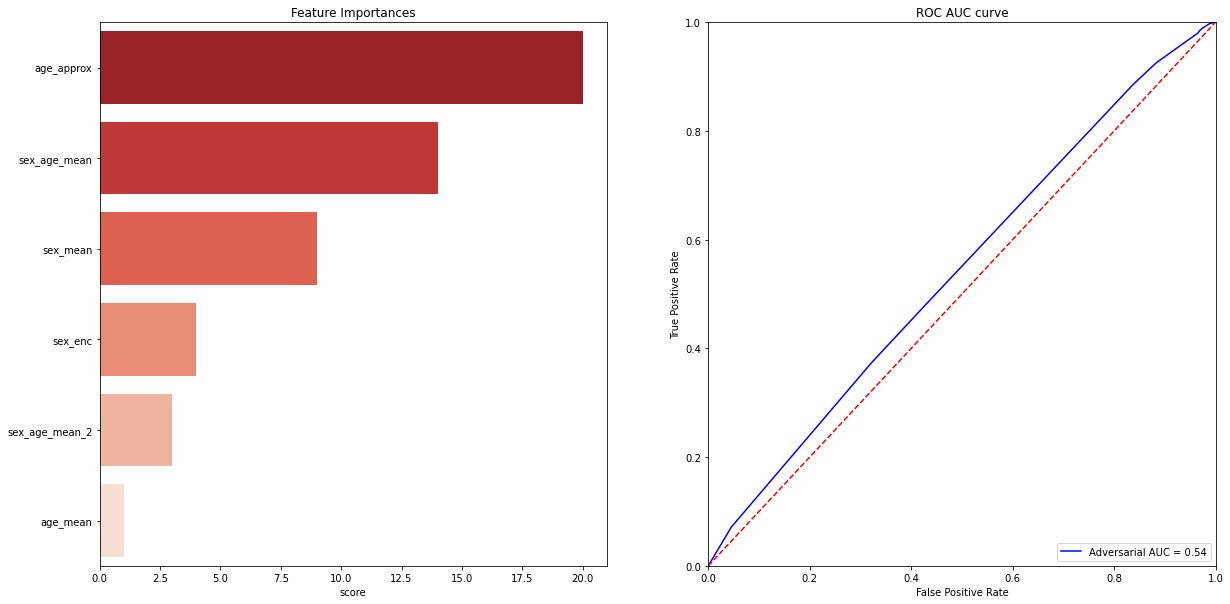

In [12]:
### Adversarial set
adv_train = train.copy()
adv_test = test.copy()
adv_train['dataset'] = 1
adv_test['dataset'] = 0

x_adv = pd.concat([adv_train, adv_test], axis=0)
y_adv = x_adv['dataset']

### Adversarial model
model_adv = XGBClassifier(**params, random_state=SEED)

model_adv.fit(x_adv[features], y_adv, eval_metric='auc', verbose=0)


### Preds
preds = model_adv.predict_proba(x_adv[features])[:, 1]


### Plot feature importance and ROC AUC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Feature importance
feature_importance = model_adv.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)

ax1.set_title('Feature Importances')
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r',
            ax=ax1)

# Plot ROC AUC curve
fpr_train, tpr_train, _ = roc_curve(y_adv, preds)
roc_auc_train = auc(fpr_train, tpr_train)

ax2.set_title('ROC AUC curve')
ax2.plot(fpr_train, tpr_train, color='blue', label='Adversarial AUC = %0.2f' % roc_auc_train)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

# Visualize predictions

In [13]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 5544
Train positive correct predictions: 239
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.411201,0.425702,0.403335,0.420640,0.405444,0.400883
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.419420,0.424776,0.401911,0.424701,0.420430,0.425281
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.383706,0.376495,0.388183,0.400698,0.374313,0.378841
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.419420,0.424776,0.401911,0.424701,0.420430,0.425281
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.446399,0.440472,0.464672,0.433692,0.452328,0.440833
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.362833,0.366301,0.359056,0.361680,0.356902,0.370227
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.470276,0.471960,0.472546,0.480176,0.460143,0.466554
7,ISIC_0075663,female,35.0,torso,unknown,0,0.389232,0.391696,0.392383,0.406026,0.375236,0.380818
8,ISIC_0075914,male,30.0,torso,unknown,0,0.448797,0.458865,0.465172,0.437839,0.447221,0.434891
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.383706,0.376495,0.388183,0.400698,0.374313,0.378841


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.446399,0.440472,0.464672,0.433692,0.452328,0.440833
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.383706,0.376495,0.388183,0.400698,0.374313,0.378841
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.444718,0.436977,0.462894,0.434017,0.451067,0.438634
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.512058,0.508188,0.516481,0.518330,0.514570,0.502718
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.507539,0.498981,0.505048,0.518330,0.512615,0.502718
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.616539,0.624258,0.592506,0.620652,0.623491,0.621786
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.389232,0.391696,0.392383,0.406026,0.375236,0.380818
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.626088,0.635956,0.615522,0.624699,0.626687,0.627577
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.512058,0.508188,0.516481,0.518330,0.514570,0.502718
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.448797,0.458865,0.465172,0.437839,0.447221,0.434891


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
11,ISIC_0076742,male,75.0,upper extremity,unknown,0,0.616539,0.624258,0.592506,0.620652,0.623491,0.621786
14,ISIC_0077735,male,70.0,torso,unknown,0,0.521574,0.513065,0.520273,0.526188,0.522947,0.525396
17,ISIC_0079038,male,70.0,torso,unknown,0,0.521574,0.513065,0.520273,0.526188,0.522947,0.525396
18,ISIC_0080512,male,75.0,torso,unknown,0,0.616539,0.624258,0.592506,0.620652,0.623491,0.621786
24,ISIC_0082934,male,65.0,torso,unknown,0,0.512058,0.508188,0.516481,0.518330,0.514570,0.502718
30,ISIC_0085718,female,65.0,torso,unknown,0,0.507539,0.498981,0.505048,0.518330,0.512615,0.502718
43,ISIC_0090279,female,65.0,torso,unknown,0,0.507539,0.498981,0.505048,0.518330,0.512615,0.502718
51,ISIC_0094775,male,75.0,torso,unknown,0,0.616539,0.624258,0.592506,0.620652,0.623491,0.621786
52,ISIC_0095805,female,65.0,torso,unknown,0,0.507539,0.498981,0.505048,0.518330,0.512615,0.502718
55,ISIC_0096328,female,75.0,torso,unknown,0,0.573388,0.567600,0.586072,0.565070,0.565624,0.582577


# Visualize test predictions

In [14]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 2034|8948
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.521574,0.513065,0.520273,0.526188,0.522947,0.525396
1,ISIC_0052349,male,40.0,lower extremity,0.369580,0.372019,0.374096,0.361986,0.367782,0.372019
2,ISIC_0058510,female,55.0,torso,0.446399,0.440472,0.464672,0.433692,0.452328,0.440833
3,ISIC_0073313,female,50.0,torso,0.383706,0.376495,0.388183,0.400698,0.374313,0.378841
4,ISIC_0073502,female,45.0,lower extremity,0.419420,0.424776,0.401911,0.424701,0.420430,0.425281
5,ISIC_0074618,male,50.0,lower extremity,0.440034,0.435788,0.454338,0.429906,0.444376,0.435763
6,ISIC_0076801,male,45.0,upper extremity,0.411201,0.425702,0.403335,0.420640,0.405444,0.400883
7,ISIC_0077586,male,50.0,lower extremity,0.440034,0.435788,0.454338,0.429906,0.444376,0.435763
8,ISIC_0082004,female,45.0,torso,0.419420,0.424776,0.401911,0.424701,0.420430,0.425281
9,ISIC_0082785,male,65.0,lower extremity,0.512058,0.508188,0.516481,0.518330,0.514570,0.502718


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.521574,0.513065,0.520273,0.526188,0.522947,0.525396
9,ISIC_0082785,male,65.0,lower extremity,0.512058,0.508188,0.516481,0.518330,0.514570,0.502718
13,ISIC_0089356,female,65.0,torso,0.507539,0.498981,0.505048,0.518330,0.512615,0.502718
17,ISIC_0095790,male,65.0,torso,0.512058,0.508188,0.516481,0.518330,0.514570,0.502718
24,ISIC_0112420,female,65.0,torso,0.507539,0.498981,0.505048,0.518330,0.512615,0.502718
26,ISIC_0115798,female,65.0,lower extremity,0.507539,0.498981,0.505048,0.518330,0.512615,0.502718
29,ISIC_0131485,male,70.0,NaN,0.521574,0.513065,0.520273,0.526188,0.522947,0.525396
31,ISIC_0131978,male,85.0,torso,0.558257,0.564639,0.588042,0.543726,0.531964,0.562910
36,ISIC_0148937,male,80.0,torso,0.626088,0.635956,0.615522,0.624699,0.626687,0.627577
37,ISIC_0150213,female,65.0,torso,0.507539,0.498981,0.505048,0.518330,0.512615,0.502718


# Test set predictions

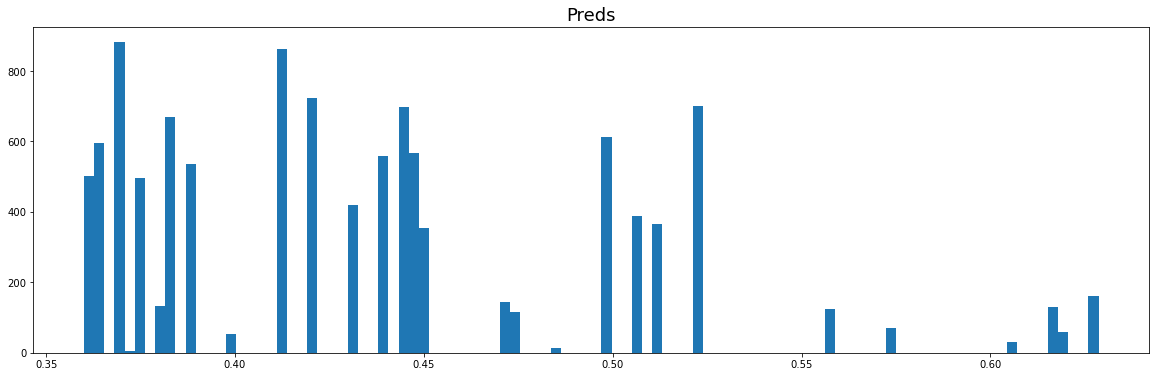

,image_name,target
0,ISIC_0052060,0.521574
1,ISIC_0052349,0.369580
2,ISIC_0058510,0.446399
3,ISIC_0073313,0.383706
4,ISIC_0073502,0.419420
5,ISIC_0074618,0.440034
6,ISIC_0076801,0.411201
7,ISIC_0077586,0.440034
8,ISIC_0082004,0.419420
9,ISIC_0082785,0.512058


,target
count,10982.000000
mean,0.436200
std,0.063486
min,0.360056
25%,0.383706
50%,0.431406
75%,0.474380
max,0.628637


In [15]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']

fig = plt.subplots(figsize=(20, 6))
plt.hist(submission['target'], bins=100)
plt.title('Preds', size=18)
plt.show()

display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)